In [1]:
##Import required Google Earth Engine python packages and check if they work in python environment
import ee
ee.Initialize()
import geetools
import geemap
import os
from geemap import cartoee
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd 

In [2]:
#import the map module that allows for attaching images to an interactive map
Map = geemap.Map()

In [3]:
#Import the river boundary from the Google Earth Engine Server
#Call in river in from a vector file saved into Google Earth Engine
Study_Area = ee.FeatureCollection("users/pjf927/Chile_Project/Study_Area")
#Some function require geometry values to clip features
Study_Area_Geom = Study_Area.geometry() 

Big_Study_Area = ee.FeatureCollection("users/pjf927/Chile_Project/Study_Area_Big")

#Add river boundary to the map
Map.addLayer(Study_Area, name = "Study_Area")
Map.addLayer(Big_Study_Area, name = "Big_Study_Area")

#Display the images centered at the whole coverage of the vector file
Map.centerObject(Big_Study_Area, 13);
Map

Map(center=[-33.47385665572837, -70.83305894881653], controls=(WidgetControl(options=['position', 'transparent…

In [4]:
#Import date csv from cloud score code as a pandas dataframe
df = pd.read_csv(r"D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\csv\Cloud_Score_Acquisition_Data.csv", index_col=0)
print(df)

#Convert a dataframe column to a list, check the data type, and print all the dates
df_dates = df['Date'].tolist()
print("df_list is type: ", type(df_dates))
print("Dates in Imagecollection: ", df_dates)

           Date     Sensor  Swath_Row  Cloud_Percent
0    2002-01-08  LANDSAT_5         83       0.016057
1    2002-02-01  LANDSAT_7         83       0.000000
2    2002-02-17  LANDSAT_7         83       0.171921
3    2002-02-25  LANDSAT_5         83       0.168117
4    2002-03-05  LANDSAT_7         83       0.011758
..          ...        ...        ...            ...
308  2022-02-16  LANDSAT_8         83       0.000000
309  2022-04-05  LANDSAT_8         83       0.188003
310  2022-10-14  LANDSAT_8         83       0.014110
311  2022-11-22  LANDSAT_7         83       0.189771
312  2022-12-01  LANDSAT_8         83       0.000299

[313 rows x 4 columns]
df_list is type:  <class 'list'>
Dates in Imagecollection:  ['2002-01-08', '2002-02-01', '2002-02-17', '2002-02-25', '2002-03-05', '2002-03-21', '2002-09-13', '2002-09-29', '2002-10-31', '2002-12-02', '2002-12-18', '2003-01-03', '2003-01-19', '2003-02-04', '2003-02-20', '2003-03-24', '2003-04-09', '2003-10-02', '2003-10-10', '2003-10-18',

In [5]:
#Create a function that creates a new dictionary in the image collection called 'Date' and converts the 'system:time_start' list to a "YYYY-MM-dd" format
def addTime(x):
  return x.set('Date', ee.Date(x.get('system:time_start')).format("YYYY-MM-dd")) #Make sure Created date list matches this format

In [6]:
#Call in Landsat 5 Level 2, Collection 2, Tier 1 dataset 
LS5_SR = (
    ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    .filterBounds(Big_Study_Area) #Filter only swath grids that cover the TN River Boundary
    .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']) #Assign imagery bands new names
    .filterDate("2002-1-1", "2012-05-05") #Filter Dates of Landsat acquisitions
    #.filterMetadata('CLOUD_COVER', 'less_than', 5)
    .map(addTime) #Apply the mapping function to create the new dictionary list 'Date'
    #.filter(ee.Filter.eq('WRS_ROW', 36)) #Filter swath grids that completly cover the largets portion of the TN River Boundary
    .filter(ee.Filter.inList('Date', ee.List(df_dates))) #Filter out dates from the new dictionary list called 'Date' comparing the dates from the csv imported eariler   
    .sort('system:time_start') #Sort collection by acquisition time
)

#Call in Landsat 7 Level 2, Collection 2, Tier 1 dataset 
LS7_SR = (
    ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
    .filterBounds(Big_Study_Area) #Filter only swath grids that cover the TN River Boundary
    .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']) #Assign imagery bands new names
    .filterDate("2002-1-1", "2022-11-25") #Filter Dates of Landsat acquisitions
    #.filterMetadata('CLOUD_COVER', 'less_than', 5)
    .map(addTime) #Apply the mapping function to create the new dictionary list 'Date'
    #.filter(ee.Filter.eq('WRS_ROW', 36)) #Filter swath grids that completly cover the largets portion of the TN River Boundary
    .filter(ee.Filter.inList('Date', ee.List(df_dates))) #Filter out dates from the new dictionary list called 'Date' comparing the dates from the csv imported eariler 
    .sort('system:time_start') #Sort collection by acquisition time
)

#Call in Landsat 8 Level 2, Collection 2, Tier 1 dataset 
LS8_SR = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(Big_Study_Area) #Filter only swath grids that cover the TN River Boundary
    .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']) #Assign imagery bands new names
    #.filterMetadata('CLOUD_COVER', 'less_than', 5)
    .map(addTime)
    #.filter(ee.Filter.eq('WRS_ROW', 36)) #Filter swath grids that completly cover the largets portion of the TN River Boundary
    .filter(ee.Filter.inList('Date', ee.List(df_dates))) #Filter out dates from the new dictionary list called 'Date' comparing the dates from the csv imported eariler 
    .sort('system:time_start') #Sort collection by acquisition time
)

LS5_count = LS5_SR.size().getInfo()
print("Landsat 5 Images: ", LS5_count)

LS7_count = LS7_SR.size().getInfo()
print("Landsat 7 Images: ", LS7_count)

LS8_count = LS8_SR.size().getInfo()
print("Landsat 8 Images: ", LS8_count)

#Merge all image collections to a newly created image collection called All_SR
All_SR = LS5_SR.merge(LS7_SR.merge(LS8_SR)).sort('system:time_start')

#Get a count of all images in the Landsat Top of Atmosphere Collection
count = All_SR.size().getInfo()
print("Images: ", count)

Landsat 5 Images:  55
Landsat 7 Images:  175
Landsat 8 Images:  83
Images:  313


In [7]:
#Check to see if the sensors are organized by date, by observing back and forth changes when the sensor appears
Sensor = All_SR.aggregate_array("SPACECRAFT_ID").getInfo()
print(Sensor)

['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5', 'LANDSAT_7', 'LANDSAT_5'

In [8]:
#Create a list of swath row acquisitions and print them out
Swath = All_SR.aggregate_array("WRS_ROW").getInfo()
print(Swath)

[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83,

In [9]:
#Clip out all pixels that are AROUND the TN River boundary and save as a new Image Collection using the lambda function
All_SR_Bounds = All_SR.map(lambda image: image.clip(Big_Study_Area))

In [10]:
#Create fucntion that calcualtes the NDTI index 
def NDVI(image):
    nir = image.select('NIR') #Create a variable that selects the blue band
    red = image.select('Red') #Create a variable that selects the red band
    #Run the '(Red - Blue) / (Red + Blue)' equation
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI') #Run the '(Red - Blue) / (Red + Blue)' equation
    return ndvi

In [11]:
#Apply each equation to the clipped pixels that are in the TN River boundary
NDVI_images = All_SR_Bounds.map(NDVI)

In [12]:
#Create a list that collects that orders the images so they can be mapped to the dates
True_list = All_SR_Bounds.toList(All_SR_Bounds.size())
NDVI_list = NDVI_images.toList(All_SR_Bounds.size())

In [13]:
#True color iterate images to add map to layer, export to local directory, and export to Google Drive
for index in range(0, count):
    image = ee.Image(True_list.get(index))
    layer_name = "True_" + str(df_dates[index]) + "_" + str(Sensor[index])
    TRUE_file = os.path.join(r'D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True', layer_name + ".tif")
    geemap.ee_export_image(image, filename = TRUE_file, scale = 30, region = Study_Area_Geom, file_per_band = False)
    #geemap.ee_export_image_to_drive(image, description = layer_name, folder = 'export', scale =30) #Takes awhile

Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-01-08_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-02-01_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-02-17_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-02-25_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-03-05_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-03-21_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2002-09-13_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-01-14_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-01-22_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-01-30_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-02-15_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-02-23_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-03-02_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-03-10_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2004-03-18_LANDSAT_5

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-01-27_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-02-04_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-02-12_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-02-20_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-02-28_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-03-08_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-03-16_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2006-09-24_LANDSAT_7

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-01-01_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-01-17_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-01-25_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-02-02_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-02-10_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-02-18_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-02-26_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2008-03-05_LANDSAT_7

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-03-08_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-03-16_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-09-24_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-10-26_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-11-11_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-11-27_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-12-05_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2009-12-21_LANDSAT_7

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-01-01_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-01-25_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-02-02_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-02-26_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-03-22_LANDSAT_5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-03-30_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-11-25_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2011-12-11_LANDSAT_7

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2013-11-22_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2013-12-16_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2014-01-01_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2014-01-09_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2014-01-25_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2014-02-02_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2014-02-10_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2014-02-26_LANDSAT_8

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-03-17_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-04-02_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-04-10_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-09-01_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-10-11_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-11-20_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-11-28_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2015-12-14_LANDSAT_8

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-01-17_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-01-25_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-02-02_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-02-18_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-03-06_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-03-22_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-03-30_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2017-08-21_LANDSAT_7

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2018-11-04_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2018-11-20_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2018-11-28_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2018-12-06_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2018-12-22_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2018-12-30_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2019-01-15_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2019-01-23_LANDSAT_8

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-01-18_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-01-26_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-02-03_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-02-11_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-02-19_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-02-27_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-03-06_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2020-03-14_LANDSAT_8

Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-10-19_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-10-27_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-11-12_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-11-20_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-11-28_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-12-14_LANDSAT_8.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-12-22_LANDSAT_7.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\True\True_2021-12-30_LANDSAT_8

In [13]:
#NDTI iterate images to add map to layer, export to local directory, and export to Google Drive
for index in range(0, count):
    image = ee.Image(NDVI_list.get(index))
    layer_name = "NDVI_" + str(df_dates[index]) + "_" + str(Sensor[index])
    NDVI_file = os.path.join(r'D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI', layer_name + ".tif")
    geemap.ee_export_image(image, filename = NDVI_file, scale = 30, region = Study_Area_Geom, file_per_band = True)

Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI


Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...


Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...


Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...


Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...


Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...
Please wait ...
Data downloaded to D:\Azad_Lab\Chile_Proj\Code\Landsat\Data\NDVI
Generating URL ...


In [13]:
#Applies scaling factors so images are better looking for displaying it graphs
def applyScaleFactors(image):
  opticalBands = image.select(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']).multiply(0.0000275).add(-0.2)
  return image.addBands(opticalBands, None, True) 

In [14]:
#Applies the scaling factor to the image collection that has pixels AROUND the TN River boundary
All_SR_Bounds_Scale = All_SR_Bounds.map(applyScaleFactors)

In [15]:
#Visualization parameters to be added to a graph
vis_params = {
  'bands': ['Red', 'Green', 'Blue'],
  'min': 0.0,
  'max': 0.3,
}

In [16]:
#Set up Graph Parameters
#The square of the study reagion in WGS84 coorinates
region = [-70.8082, -33.5025, -70.8582, -33.445] 

#Size of the figure to be plotted
fig = plt.figure(figsize=(20, 10))

#Add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.90, 0.9),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}

#Add Scale Bar
scale_bar_dict = {
    "length": 1,
    "xy": (0.5, 0.05),
    "linewidth": 3,
    "fontsize": 12,
    "color": "white",
    "unit": "mile",
    "ha": "center",
    "va": "bottom",
}

<Figure size 2000x1000 with 0 Axes>

Text(0.5, 1.0, 'Chile')

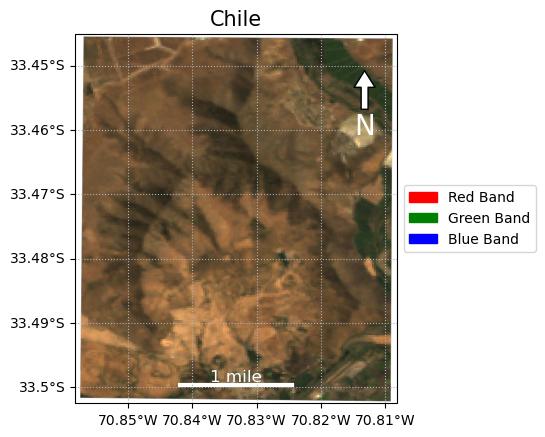

In [17]:
#Test to see if visualization parameters look good and test out the north arrow and scale bar
#Call in first image of an image collecction
True_Image = ee.Image(All_SR_Bounds_Scale.first())

#Use cartoee to get a map and create one mapping axis
ax = cartoee.get_map(True_Image, region=region, vis_params=vis_params)

#Add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.01, 0.01], linestyle=":")

#Add the north arrow 
cartoee.add_north_arrow(ax, **north_arrow_dict)

#Add the scale bar
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

#Add a legend that displays the colored bands
red_patch = mpatches.Patch(color='red', label='Red Band')
green_patch = mpatches.Patch(color='green', label='Green Band')
blue_patch = mpatches.Patch(color='blue', label='Blue Band')

#Add the lengend to the side of the map
ax.legend(handles=[red_patch, green_patch, blue_patch], loc='center left', bbox_to_anchor=(1, 0.5))

#Add the title to the top of the map
ax.set_title(label='Chile', fontsize=15)

In [18]:
#Create a timelapse animation of all the images in the image collection with the north arrow and scale bar
cartoee.get_image_collection_gif(
    ee_ic = All_SR_Bounds_Scale, #call in image collection
    out_dir = os.path.expanduser(r"D:\Azad_Lab\Chile_Proj\Code\Landsat\Map_Output\Time_Lapse_300dpi"), #Set directory
    out_gif = "animation.gif", #navisualization parameters
    vis_params=vis_params,
    region = region, #Set the location of the study area
    fps = 5, #Set oframes per second
    mp4 = True, #Output an mp4 of all png image graphs
    grid_interval = (0.2, 0.2), #Set the grid lines
    plot_title = 'Chile', #Add a title
    date_format = 'MM-dd-YYYY', #Set the date of the image graph
    fig_size = (10, 8), #Set font size
    dpi_plot = 300, #Set resolution
    file_format = "png", #Output each graph as a png file
    north_arrow_dict = north_arrow_dict, #Add in north arrow
    scale_bar_dict = scale_bar_dict, #Add in scale bar
    verbose = True, #display each downloaded image graph when it gets created
)

GIF saved to D:\Azad_Lab\Chile_Proj\Code\Landsat\Map_Output\Time_Lapse_300dpi\animation.gif
MP4 saved to D:\Azad_Lab\Chile_Proj\Code\Landsat\Map_Output\Time_Lapse_300dpi\animation.mp4
